### In this script, DBN is run on the all the sessions
### In this script, DBN is run with 1s time bin, 3 time lag 
### In this script, the animal tracking is done with only one camera - camera 2 (middle) 
#### this script focuses on the summarizing results pooling all four animals (two dyads); it can only be run after the "3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents"

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [247]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [248]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [249]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [250]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [251]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [252]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [253]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [254]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [255]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [256]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)
### separate each session based on trial types (different force levels)

In [257]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 1*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = '_allsessions'
    

# force manipulation type
# SR_bothchange: self reward, both forces changed
# CO_bothchange: 1s cooperation, both forces changed
# CO_A1change: 1s cooperation, animal 1 forces changed
# CO_A2change: 1s cooperation, animal 2 forces changed
forceManiTypes = ['SR_bothchange','CO_A1change','CO_A2change',]
nforceManiTypes = np.shape(forceManiTypes)[0]

#  
animal1_fixedorders = ['koala','dannon']
animal2_fixedorders = ['vermelho','kanga']

animal1_filenames = ["Koala","Dannon"]
animal2_filenames = ["Vermelho","Kanga"]

nanimalpairs = np.shape(animal1_fixedorders)[0]


# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_forceManipulation_task_data_saved/'


    

In [258]:
# load data for all animals
summary_all_results = pd.DataFrame(columns=['date','forceContType','self_animal','partner_animal','subblockID',
                                            'self_force','partner_force','trialnum','blocktime',
                                            'succ_rate','gaze_number','pull_number',
                                            'AcroAnimal_gazeDist_mean','AcroAnimal_gazeDist_shuffle',
                                            'SameAnimal_gazeDist_mean','SameAnimal_gazeDist_shuffle',
                                            'ccf_acrossAnimalsPulls','ccf_withinAnimalpullgaze','ccf_acrossAnimalspullgaze'
                                           ])

# load the data for plot
mergetempRos = 0
doBhvitv_timebin = 0

temp_resolu = 1 # temporal resolution - 1s

#
for ianimalpair in np.arange(0,nanimalpairs,1):
    
    animal1_fixedorder = [animal1_fixedorders[ianimalpair]]
    animal2_fixedorder = [animal2_fixedorders[ianimalpair]]
    
    animal1_filename = animal1_filenames[ianimalpair]
    animal2_filename = animal2_filenames[ianimalpair]
    
    # load data for all manipulation types
    for iforceManiType in np.arange(0,nforceManiTypes,1):
        
        forceManiType = forceManiTypes[iforceManiType]
        
    
        # load saved data
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'

        with open(data_saved_subfolder+'/animal1_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            animal1_name_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/animal2_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            animal2_name_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/trialdates_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            trialdates_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/force1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            force1_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/force2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            force2_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/subblockID_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            subblockID_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            succ_rate_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            trialnum_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/blocktime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            blocktime_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            owgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            owgaze2_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            mtgaze1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            mtgaze2_num_all_dates = pickle.load(f)     
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            pull1_num_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            pull2_num_all_dates = pickle.load(f)

        with open(data_saved_subfolder+'/cross_corr_bhv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
            cross_corr_bhv_all_dates = pickle.load(f)
            
        # load the gaze distribution data
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'

        if not mergetempRos:
            if doBhvitv_timebin:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes =pickle.load(f)
                #
                with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    SameAnimal_gazeDist_mean_all=pickle.load(f)
                with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    AcroAnimal_gazeDist_mean_all=pickle.load(f)
                with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    SameAnimal_gazeDist_shuffle_all=pickle.load(f)
                with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    AcroAnimal_gazeDist_shuffle_all=pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes=pickle.load(f)
                #
                with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    SameAnimal_gazeDist_mean_all=pickle.load(f)
                with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    AcroAnimal_gazeDist_mean_all=pickle.load(f)
                with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    SameAnimal_gazeDist_shuffle_all=pickle.load(f)
                with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    AcroAnimal_gazeDist_shuffle_all=pickle.load(f)
        else:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes=pickle.load(f) 
            #
            with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
                SameAnimal_gazeDist_mean_all=pickle.load(f)
            with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
                AcroAnimal_gazeDist_mean_all=pickle.load(f)
            with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
                SameAnimal_gazeDist_shuffle_all=pickle.load(f)
            with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
                AcroAnimal_gazeDist_shuffle_all=pickle.load(f)

        print('all data are loaded:'+animal1_fixedorder[0]+' '+animal2_fixedorder[0]+' '+forceManiType)

        # 
        ndates = np.shape(trialdates_all_dates)[0]
        
        for idate in np.arange(0,ndates,1):
            
            if forceManiType == 'SR_bothchange':
                animal1_forceContType = 'self_change_SR'
                animal2_forceContType = 'self_change_SR'
            elif forceManiType == 'CO_A1change':
                animal1_forceContType = 'self_change_MC'
                animal2_forceContType = 'partner_change_MC'
            elif forceManiType == 'CO_A2change':
                animal1_forceContType = 'partner_change_MC'
                animal2_forceContType = 'self_change_MC'
            else:
                animal1_forceContType = None
                animal2_forceContType = None
             
            # cross correlation between bhv variables
            cross_corr_allbhv_tgt = cross_corr_bhv_all_dates[trialdates_all_dates[idate]][str(int(force1_all_dates[idate]))+'&'+str(int(force2_all_dates[idate]))]
            #
            # center at pull1, xcorr of pull2
            cross_corr_allbhv_pull1pull2 = cross_corr_allbhv_tgt['pull1']['pull2']
            # center at pull1, xcorr of gaze1
            cross_corr_allbhv_pull1gaze1 = cross_corr_allbhv_tgt['pull1']['gaze1']
            # center at pull1, xcorr of gaze2
            cross_corr_allbhv_pull1gaze2 = cross_corr_allbhv_tgt['pull1']['gaze2']
            #
            # center at pull2, xcorr of pull1
            cross_corr_allbhv_pull2pull1 = cross_corr_allbhv_tgt['pull2']['pull1']
            # center at pull2, xcorr of gaze2
            cross_corr_allbhv_pull2gaze2 = cross_corr_allbhv_tgt['pull2']['gaze2']
            # center at pull2, xcorr of gaze1
            cross_corr_allbhv_pull2gaze1 = cross_corr_allbhv_tgt['pull2']['gaze1']
            
            # for animal1
            forcecombined = str(int(force1_all_dates[idate]))+'&'+str(int(force2_all_dates[idate]))
            
            AcroAnimal_gazeDist_mean = AcroAnimal_gazeDist_mean_all[animal1_fixedorder[0]][trialdates_all_dates[idate]][forcecombined]
            AcroAnimal_gazeDist_shuffle = AcroAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][trialdates_all_dates[idate]][forcecombined]
            SameAnimal_gazeDist_mean = SameAnimal_gazeDist_mean_all[animal1_fixedorder[0]][trialdates_all_dates[idate]][forcecombined]
            SameAnimal_gazeDist_shuffle = SameAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][trialdates_all_dates[idate]][forcecombined]
           
            summary_all_results = summary_all_results.append({
                                                        'date': trialdates_all_dates[idate],
                                                        'forceContType':animal1_forceContType,
                                                        'self_animal': animal1_fixedorder[0],
                                                        'partner_animal': animal2_fixedorder[0],
                                                        'subblockID': subblockID_all_dates[idate],
                                                        'self_force': force1_all_dates[idate],
                                                        'partner_force': force2_all_dates[idate],
                                                        'trialnum': trialnum_all_dates[idate],
                                                        'blocktime': blocktime_all_dates[idate],
                                                        'succ_rate': succ_rate_all_dates[idate],
                                                        'gaze_number': owgaze1_num_all_dates[idate]+mtgaze1_num_all_dates[idate],
                                                        'pull_number': pull1_num_all_dates[idate],
                                                        'AcroAnimal_gazeDist_mean':AcroAnimal_gazeDist_mean,
                                                        'AcroAnimal_gazeDist_shuffle':AcroAnimal_gazeDist_shuffle,
                                                        'SameAnimal_gazeDist_mean':SameAnimal_gazeDist_mean,
                                                        'SameAnimal_gazeDist_shuffle':SameAnimal_gazeDist_shuffle,  
                                                        'ccf_acrossAnimalsPulls':cross_corr_allbhv_pull1pull2,
                                                        'ccf_withinAnimalpullgaze':cross_corr_allbhv_pull1gaze1,
                                                        'ccf_acrossAnimalspullgaze':cross_corr_allbhv_pull2gaze1,
                                                    }, ignore_index=True)
            
            # for animal2
            forcecombined = str(int(force1_all_dates[idate]))+'&'+str(int(force2_all_dates[idate]))
            
            AcroAnimal_gazeDist_mean = AcroAnimal_gazeDist_mean_all[animal2_fixedorder[0]][trialdates_all_dates[idate]][forcecombined]
            AcroAnimal_gazeDist_shuffle = AcroAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][trialdates_all_dates[idate]][forcecombined]
            SameAnimal_gazeDist_mean = SameAnimal_gazeDist_mean_all[animal2_fixedorder[0]][trialdates_all_dates[idate]][forcecombined]
            SameAnimal_gazeDist_shuffle = SameAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][trialdates_all_dates[idate]][forcecombined]
           
            summary_all_results = summary_all_results.append({
                                                        'date': trialdates_all_dates[idate],
                                                        'forceContType':animal2_forceContType,
                                                        'self_animal': animal2_fixedorder[0],
                                                        'partner_animal': animal1_fixedorder[0],
                                                        'subblockID': subblockID_all_dates[idate],
                                                        'self_force': force2_all_dates[idate],
                                                        'partner_force': force1_all_dates[idate],
                                                        'trialnum': trialnum_all_dates[idate],
                                                        'blocktime': blocktime_all_dates[idate],
                                                        'succ_rate': succ_rate_all_dates[idate],
                                                        'gaze_number': owgaze2_num_all_dates[idate]+mtgaze2_num_all_dates[idate],
                                                        'pull_number': pull2_num_all_dates[idate],
                                                        'AcroAnimal_gazeDist_mean':AcroAnimal_gazeDist_mean,
                                                        'AcroAnimal_gazeDist_shuffle':AcroAnimal_gazeDist_shuffle,
                                                        'SameAnimal_gazeDist_mean':SameAnimal_gazeDist_mean,
                                                        'SameAnimal_gazeDist_shuffle':SameAnimal_gazeDist_shuffle,
                                                        'ccf_acrossAnimalsPulls':cross_corr_allbhv_pull2pull1,
                                                        'ccf_withinAnimalpullgaze':cross_corr_allbhv_pull2gaze2,
                                                        'ccf_acrossAnimalspullgaze':cross_corr_allbhv_pull1gaze2,
                                                    }, ignore_index=True)


# calculating gaze and pull number per second
summary_all_results['gazenum_pers'] = summary_all_results['gaze_number']/summary_all_results['blocktime']
summary_all_results['pullnum_pers'] = summary_all_results['pull_number']/summary_all_results['blocktime']

# remove entries that has too few trial number
trialnum_threshold = 5

ind_bad = summary_all_results['trialnum']<trialnum_threshold

summary_all_results = summary_all_results[~ind_bad].reset_index(drop=True)



all data are loaded:koala vermelho SR_bothchange
all data are loaded:koala vermelho CO_A1change
all data are loaded:koala vermelho CO_A2change
all data are loaded:dannon kanga SR_bothchange
all data are loaded:dannon kanga CO_A1change
all data are loaded:dannon kanga CO_A2change


In [259]:
# create dataframe for the version that force and success rate and other variables are separated into quantiles
summary_all_results_quantile = summary_all_results.copy()

unique_combinations = summary_all_results[['date', 'self_animal']].drop_duplicates()
ncombines = np.shape(unique_combinations)[0]

columns_todo = ['self_force','partner_force','succ_rate','subblockID','gazenum_pers','pullnum_pers']
# columns_todo = ['succ_rate','subblockID','gazenum_pers','pullnum_pers']
ntodos = np.shape(columns_todo)[0]

for icombine in np.arange(0,ncombines,1):
    
    date_tgt = list(unique_combinations['date'])[icombine]
    selfanimal_tgt = list(unique_combinations['self_animal'])[icombine]
    
    # for normal dataset
    ind_tgt = (summary_all_results_quantile['date']==date_tgt)&\
    (summary_all_results_quantile['self_animal']==selfanimal_tgt)
    
    for itodo in np.arange(0,ntodos,1):
        column_todo = columns_todo[itodo]

        yyy = np.array(summary_all_results_quantile[column_todo][ind_tgt])
        
        # only one kind of force
        if np.shape(np.unique(yyy))[0] == 1:
            yyy_quant = np.ones(np.shape(yyy))*1
        # two kinds of force
        elif np.shape(np.unique(yyy))[0] == 2:
            ranks = st.rankdata(yyy, method='average')  # Average ranks for ties
            # yyy_quant = (np.ceil(ranks / len(yyy) * 2)-1)*2+1 # separate into three quantiles
            yyy_quant = (np.ceil(ranks / len(yyy) * 2)) # separate into two quantiles         
        # more than two kinds of force,
        else:
            ranks = st.rankdata(yyy, method='average')  # Average ranks for ties
            # yyy_quant = np.ceil(ranks / len(yyy) * 3) # separate into three quantiles
            yyy_quant = (np.ceil(ranks / len(yyy) * 2)) # separate into two quantiles
        
        # Update the DataFrame with residuals for the current column
        summary_all_results_quantile.loc[ind_tgt, column_todo] = yyy_quant
    
print('create dataframe for the version that force and other variables is defined into quantiles')
# print('create dataframe for the version that variables other than force is defined into quantiles')

# summary_all_results_quantile

create dataframe for the version that force and other variables is defined into quantiles


In [260]:
# create dataframe for the version that force are refered to the first block and then separated into quantiles
if 0: 
    # summary_all_results_quantile = summary_all_results.copy()

    unique_combinations = summary_all_results[['date', 'self_animal']].drop_duplicates()
    ncombines = np.shape(unique_combinations)[0]

    columns_todo = ['self_force','partner_force',]
    ntodos = np.shape(columns_todo)[0]

    for icombine in np.arange(0,ncombines,1):

        date_tgt = list(unique_combinations['date'])[icombine]
        selfanimal_tgt = list(unique_combinations['self_animal'])[icombine]

        # for normal dataset
        ind_tgt = (summary_all_results_quantile['date']==date_tgt)&\
        (summary_all_results_quantile['self_animal']==selfanimal_tgt)

        for itodo in np.arange(0,ntodos,1):
            column_todo = columns_todo[itodo]

            yyy = np.array(summary_all_results_quantile[column_todo][ind_tgt])

            # two steps: 
            # step 1 - refer to the force of the first block; 
            # step 2 - two 'quantile': 1 for smaller than and same as first block; 2 for larger than the first block        
            yyy_new = yyy - yyy[0]
            yyy_quant = np.ones(np.shape(yyy_new))
            yyy_quant[yyy_new>=0] = 2

            # Update the DataFrame with residuals for the current column
            summary_all_results_quantile.loc[ind_tgt, column_todo] = yyy_quant



    print('create dataframe for the version that force is defined into quantiles based on the reference to the first block')

    # summary_all_results_quantile

In [261]:
# create dataframe for the version that force are separated into quantiles,but based on the refered to the previous block
if 0: 
    # summary_all_results_quantile = summary_all_results.copy()

    unique_combinations = summary_all_results[['date', 'self_animal']].drop_duplicates()
    ncombines = np.shape(unique_combinations)[0]

    columns_todo = ['partner_force','self_force',]
    ntodos = np.shape(columns_todo)[0]

    for icombine in np.arange(0,ncombines,1):

        date_tgt = list(unique_combinations['date'])[icombine]
        selfanimal_tgt = list(unique_combinations['self_animal'])[icombine]

        # for normal dataset
        ind_tgt = (summary_all_results_quantile['date']==date_tgt)&\
        (summary_all_results_quantile['self_animal']==selfanimal_tgt)

        for itodo in np.arange(0,ntodos,1):
            column_todo = columns_todo[itodo]

            yyy = np.array(summary_all_results_quantile[column_todo][ind_tgt])

            # two steps: 
            # step 1 - refer to the force of the first block; 
            # step 2 - two 'quantile': 1 for smaller than and same as first block; 2 for larger than the first block        
            yyy_new = yyy - np.hstack((yyy[0],yyy[0:-1]))
            yyy_quant = np.ones(np.shape(yyy_new))
            yyy_quant[yyy_new>0] = 2

            # Update the DataFrame with residuals for the current column
            summary_all_results_quantile.loc[ind_tgt, column_todo] = yyy_quant



    print('create dataframe for the version that force is defined into quantiles based on the reference to the previous block')

    # summary_all_results_quantile

In [262]:
# create dataframe for the version that force are separated into quantiles, based on the value cluster
if 0: 
    from sklearn.cluster import KMeans
    
    # summary_all_results_quantile = summary_all_results.copy()
    unique_combinations = summary_all_results[['date', 'self_animal']].drop_duplicates()
    ncombines = np.shape(unique_combinations)[0]

    columns_todo = ['self_force','partner_force',]
    ntodos = np.shape(columns_todo)[0]

    for icombine in np.arange(0,ncombines,1):

        date_tgt = list(unique_combinations['date'])[icombine]
        selfanimal_tgt = list(unique_combinations['self_animal'])[icombine]

        # for normal dataset
        ind_tgt = (summary_all_results_quantile['date']==date_tgt)&\
        (summary_all_results_quantile['self_animal']==selfanimal_tgt)

        for itodo in np.arange(0,ntodos,1):
            column_todo = columns_todo[itodo]

            yyy = np.array(summary_all_results_quantile[column_todo][ind_tgt])
            y_array = np.array(yyy).reshape(-1, 1)
            
            # Perform k-means clustering with 2 clusters
            kmeans = KMeans(n_clusters=2, random_state=42).fit(y_array)         
            yyy_quant = kmeans.labels_ + 1

            # Update the DataFrame with residuals for the current column
            summary_all_results_quantile.loc[ind_tgt, column_todo] = yyy_quant



    print('create dataframe for the version that force is defined into quantiles based on the value cluster')

    # summary_all_results_quantile

In [263]:
np.sum(summary_all_results_quantile['self_force']==3)

0

In [264]:
# correlation between variables
summary_all_tgt = summary_all_results_quantile

ind_tgt = (summary_all_tgt['forceContType']=='self_change_MC') # & (summary_all_tgt['self_animal']=='vermelho')
summary_all_tgt = summary_all_tgt[ind_tgt]

data1 = np.array(summary_all_tgt['subblockID'])
data2 = np.array(summary_all_tgt['succ_rate'])

kendall_corr, kendall_p = st.kendalltau(data1, data2)
print(f"Kendall's tau: {kendall_corr}, p-value: {kendall_p}")


Kendall's tau: -0.25972850678733034, p-value: 0.005348185880690342


### plot the summarizing figures with all animals
#### averaged gaze distribution around pull (self pull or other pull)
#### separating condition (self sr, other sr, self mc, other mc etc)

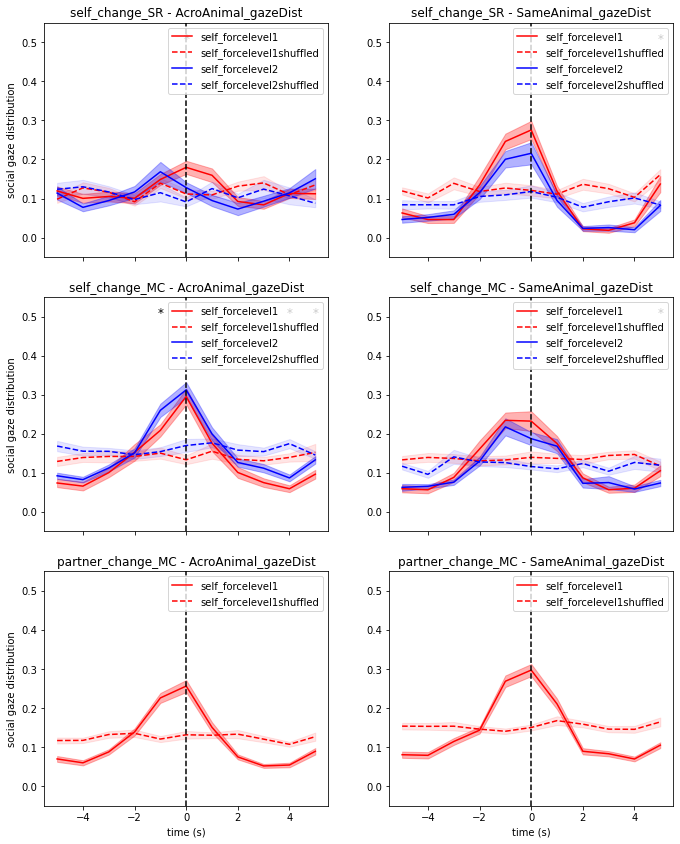

In [266]:
summary_all_tgt = summary_all_results_quantile
nTrialConds = np.shape(np.unique(summary_all_tgt['forceContType']))[0]

# xplottype = 'pullnum_pers' # 'succ_rate', 'subblockID', 'gazenum_pers', 'pullnum_pers'
xplottype = 'self_force'  # 'self_force', 'partner_force'
nxplotgroups = np.shape(np.unique(summary_all_tgt[xplottype]))[0]
xplotgroupcolors = ['red','blue','green','skyblue','purple']

yplottypes = ['AcroAnimal_gazeDist','SameAnimal_gazeDist']
nyplottypes = np.shape(yplottypes)[0]

timebins = np.arange(-5,6,1)

# Set up the figure grid
fig, axes = plt.subplots(nTrialConds, nyplottypes, 
                         figsize=(5 * nyplottypes, 4 * nTrialConds), 
                         sharex=True, sharey=False)
fig.tight_layout(pad=3.0)

# Plotting each unique condition and y-axis type
unique_conditions = summary_all_tgt['forceContType'].unique()

for i, condition in enumerate(unique_conditions):
    # Filter data for the current condition
    condition_data = summary_all_tgt[summary_all_tgt['forceContType'] == condition]
    
    for j, yplot in enumerate(yplottypes):
        ax = axes[i, j] if nTrialConds > 1 else axes[j]  # Adjust for single-row cases
        
        # create dataframe and then do statistic test
        condition_data_fortest = pd.concat([pd.DataFrame(condition_data[yplot+'_mean'].
                                                     reset_index(drop=True).values.tolist()),
                                        condition_data[xplottype].reset_index(drop=True)],axis=1)

        anova_results = {}
        for col in range(0, np.shape(condition_data_fortest)[1]-1):
            # Group the data by `partner_force`
            groups = [group[col].values for name, group in condition_data_fortest.groupby(xplottype)]
            # Filter out NaNs from each array in groups
            groups_cleaned = [g[~np.isnan(g)] for g in groups]

            # Run ANOVA on cleaned groups
            try:
                f_stat, p_value = st.f_oneway(*groups_cleaned)
            except:
                f_stat = np.nan
                p_value = np.nan
            # Store results
            anova_results[col] = {'F-statistic': f_stat, 'p-value': p_value}
        anova_results_df = pd.DataFrame(anova_results).T
        # print(anova_results_df)
     
        # for plot
        for ixplotgroup in np.arange(1,nxplotgroups+1,1):
            # group based on the force quantile
            condition_data_iforcequant = condition_data[condition_data[xplottype]==ixplotgroup]

            # real data
            data_cleaned = condition_data_iforcequant[yplot+'_mean'].reset_index(drop=True)

            data_clean_df = pd.DataFrame(data_cleaned.values.tolist())
            xxx_mean = np.nanmean(data_clean_df,axis=0)
            xxx_std = np.nanstd(data_clean_df,axis=0)/np.sqrt(np.shape(data_clean_df)[0])
            
            # shuffled data
            data_cleaned_sf = condition_data_iforcequant[yplot+'_shuffle'].reset_index(drop=True)

            data_clean_sf_df = pd.DataFrame(data_cleaned_sf.values.tolist())
            xxx_mean_sf = np.nanmean(data_clean_sf_df,axis=0)
            xxx_std_sf = np.nanstd(data_clean_sf_df,axis=0)/np.sqrt(np.shape(data_clean_sf_df)[0])
            
            
            try:
                # real data
                seaborn.lineplot(x=timebins, y=xxx_mean, ax=ax,label=xplottype+'level'+str(ixplotgroup),
                                 color = xplotgroupcolors[ixplotgroup-1])
                ax.fill_between(timebins, xxx_mean - xxx_std, xxx_mean + xxx_std, alpha=0.3,
                                color = xplotgroupcolors[ixplotgroup-1])
                # shuffled data
                seaborn.lineplot(x=timebins, y=xxx_mean_sf, ax=ax,label=xplottype+'level'+str(ixplotgroup)+'shuffled',
                                 color = xplotgroupcolors[ixplotgroup-1],linestyle='--')
                ax.fill_between(timebins, xxx_mean_sf - xxx_std_sf, xxx_mean_sf + xxx_std_sf, alpha=0.1,
                                color = xplotgroupcolors[ixplotgroup-1])
            except:
                continue
        
        ax.set_ylim([-0.05,0.55])
        ax.plot([0,0],ax.get_ylim(),'k--')
        
        # Add significance markers outside of group loop
        for col, p_value in enumerate(anova_results_df['p-value']):
            if p_value < 0.05:  # Significance threshold
                # Slight vertical offset for the marker
                ax.text(timebins[col], 0.5, '*', ha='center', color='black', fontsize=12)

        
        # Set titles and labels
        ax.set_title(f"{condition} - {yplot}")
        if i == nTrialConds - 1:
            ax.set_xlabel('time (s)')
        if j == 0:
            ax.set_ylabel('social gaze distribution')

            

plt.show()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents_allanimal_summary/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig.savefig(figsavefolder+"gaze_distribution_aligned_with_pulls_groupedas"+xplottype+".pdf")



### plot the summarizing figures with all animals - separate animals
#### averaged gaze distribution around pull (self pull or other pull)
#### separating condition (self sr, other sr, self mc, other mc etc)

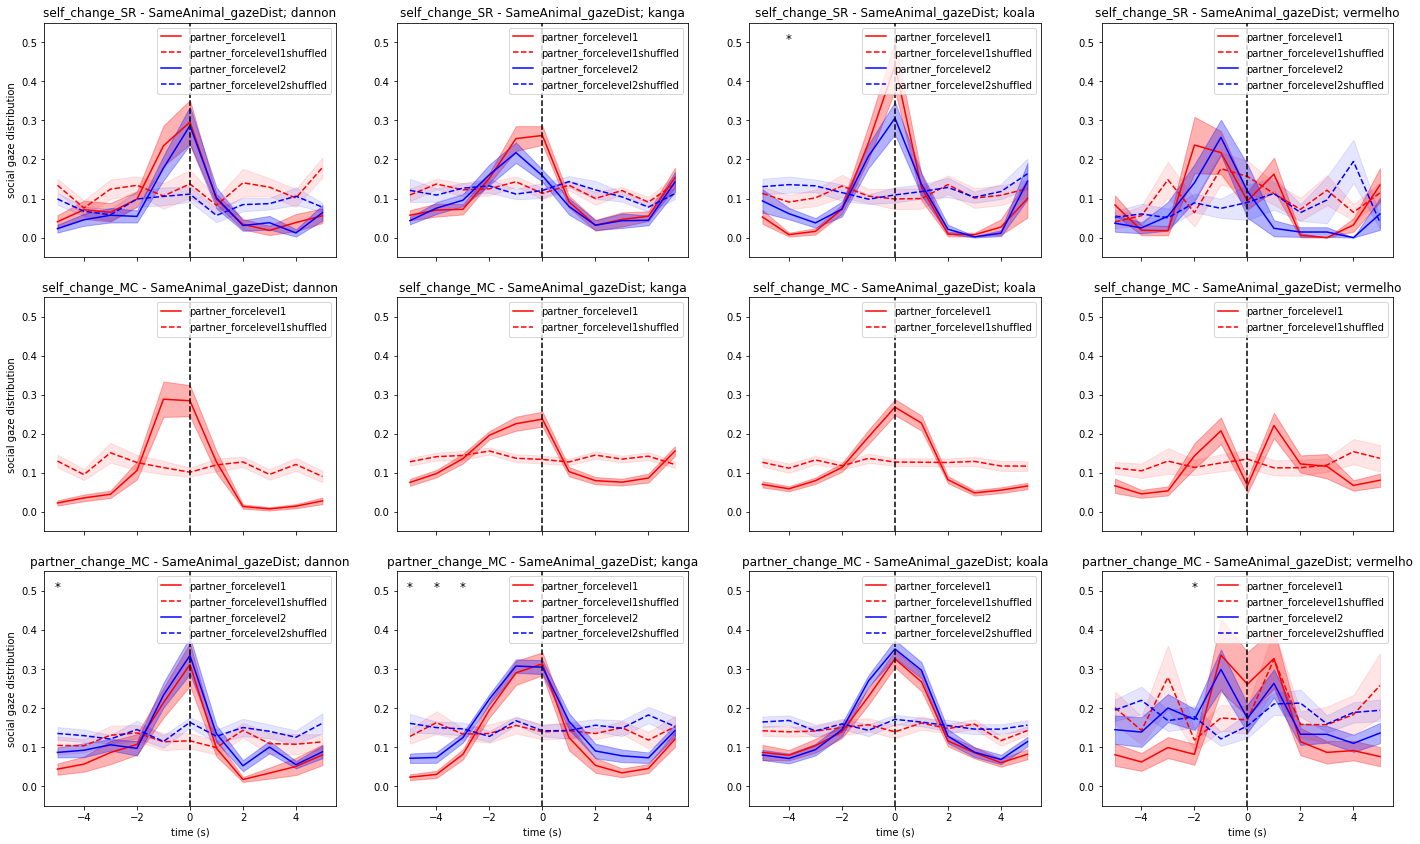

In [267]:
summary_all_tgt = summary_all_results_quantile

nTrialConds = np.shape(np.unique(summary_all_tgt['forceContType']))[0]

selfanimals = np.unique(summary_all_tgt['self_animal'])
nanimals = np.shape(selfanimals)[0]

# xplottype = 'subblockID'
xplottype = 'partner_force'  # 'self_force', 'partner_force'
nxplotgroups = np.shape(np.unique(summary_all_tgt[xplottype]))[0]
xplotgroupcolors = ['red','blue','green','skyblue','purple']

yplottype = 'SameAnimal_gazeDist'

timebins = np.arange(-5,6,1)

# Set up the figure grid
fig, axes = plt.subplots(nTrialConds, nanimals, 
                         figsize=(5 * nanimals, 4 * nTrialConds), 
                         sharex=True, sharey=False)
fig.tight_layout(pad=3.0)

# Plotting each unique condition and y-axis type
unique_conditions = summary_all_tgt['forceContType'].unique()

for i, condition in enumerate(unique_conditions):
    # Filter data for the current condition
    condition_data = summary_all_tgt[summary_all_tgt['forceContType'] == condition]
    
    for j, ianimal in enumerate(selfanimals):
        ax = axes[i, j] if nTrialConds > 1 else axes[j]  # Adjust for single-row cases
        
        condition_data_ianimal = condition_data[condition_data['self_animal']==ianimal]

        # create dataframe and then do statistic test
        condition_data_fortest = pd.concat([pd.DataFrame(condition_data_ianimal[yplottype+'_mean'].
                                                     reset_index(drop=True).values.tolist()),
                                        condition_data_ianimal[xplottype].reset_index(drop=True)],axis=1)

        anova_results = {}
        for col in range(0, np.shape(condition_data_fortest)[1]-1):
            # Group the data by `partner_force`
            groups = [group[col].values for name, group in condition_data_fortest.groupby(xplottype)]
            # Filter out NaNs from each array in groups
            groups_cleaned = [g[~np.isnan(g)] for g in groups]

            # Run ANOVA on cleaned groups
            try:
                f_stat, p_value = st.f_oneway(*groups_cleaned)
            except:
                f_stat = np.nan
                p_value = np.nan
            # Store results
            anova_results[col] = {'F-statistic': f_stat, 'p-value': p_value}
        anova_results_df = pd.DataFrame(anova_results).T
        # print(anova_results_df)
        
        
        # for plot
        for ixplotgroup in np.arange(1,nxplotgroups+1,1):
            # group based on the force quantile
            condition_data_iforcequant_ianimal = condition_data_ianimal[condition_data_ianimal[xplottype]==ixplotgroup]
 
            # real data
            data_cleaned = condition_data_iforcequant_ianimal[yplottype+'_mean'].reset_index(drop=True)

            data_clean_df = pd.DataFrame(data_cleaned.values.tolist())
            xxx_mean = np.nanmean(data_clean_df,axis=0)
            xxx_std = np.nanstd(data_clean_df,axis=0)/np.sqrt(np.shape(data_clean_df)[0])
            
            # shuffled data
            data_cleaned_sf = condition_data_iforcequant_ianimal[yplottype+'_shuffle'].reset_index(drop=True)

            data_clean_sf_df = pd.DataFrame(data_cleaned_sf.values.tolist())
            xxx_mean_sf = np.nanmean(data_clean_sf_df,axis=0)
            xxx_std_sf = np.nanstd(data_clean_sf_df,axis=0)/np.sqrt(np.shape(data_clean_sf_df)[0])
            
            try:
                # real data
                seaborn.lineplot(x=timebins, y=xxx_mean, ax=ax,label=xplottype+'level'+str(ixplotgroup),
                                 color = xplotgroupcolors[ixplotgroup-1])
                ax.fill_between(timebins, xxx_mean - xxx_std, xxx_mean + xxx_std, alpha=0.3,
                                color = xplotgroupcolors[ixplotgroup-1])
                # shuffled data
                seaborn.lineplot(x=timebins, y=xxx_mean_sf, ax=ax,label=xplottype+'level'+str(ixplotgroup)+'shuffled',
                                 color = xplotgroupcolors[ixplotgroup-1],linestyle='--')
                ax.fill_between(timebins, xxx_mean_sf - xxx_std_sf, xxx_mean_sf + xxx_std_sf, alpha=0.1,
                                color = xplotgroupcolors[ixplotgroup-1])
                
            except:
                continue
        
        ax.set_ylim([-0.05,0.55])
        ax.plot([0,0],ax.get_ylim(),'k--')
        
        # Add significance markers outside of group loop
        for col, p_value in enumerate(anova_results_df['p-value']):
            if p_value < 0.05:  # Significance threshold
                # Slight vertical offset for the marker
                ax.text(timebins[col], 0.5, '*', ha='center', color='black', fontsize=12)

        
        # Set titles and labels
        ax.set_title(f"{condition} - {yplottype}; {ianimal}")
        if i == nTrialConds - 1:
            ax.set_xlabel('time (s)')
        if j == 0:
            ax.set_ylabel('social gaze distribution')
            

plt.show()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents_allanimal_summary/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig.savefig(figsavefolder+"gaze_distribution_aligned_with_pulls_groupedas"+xplottype+"_"+yplottype+"_separateanimals.pdf")



### plot the summarizing figures with all animals
#### average cross correlation function 
#### separating condition (self sr, other sr, self mc, other mc etc)

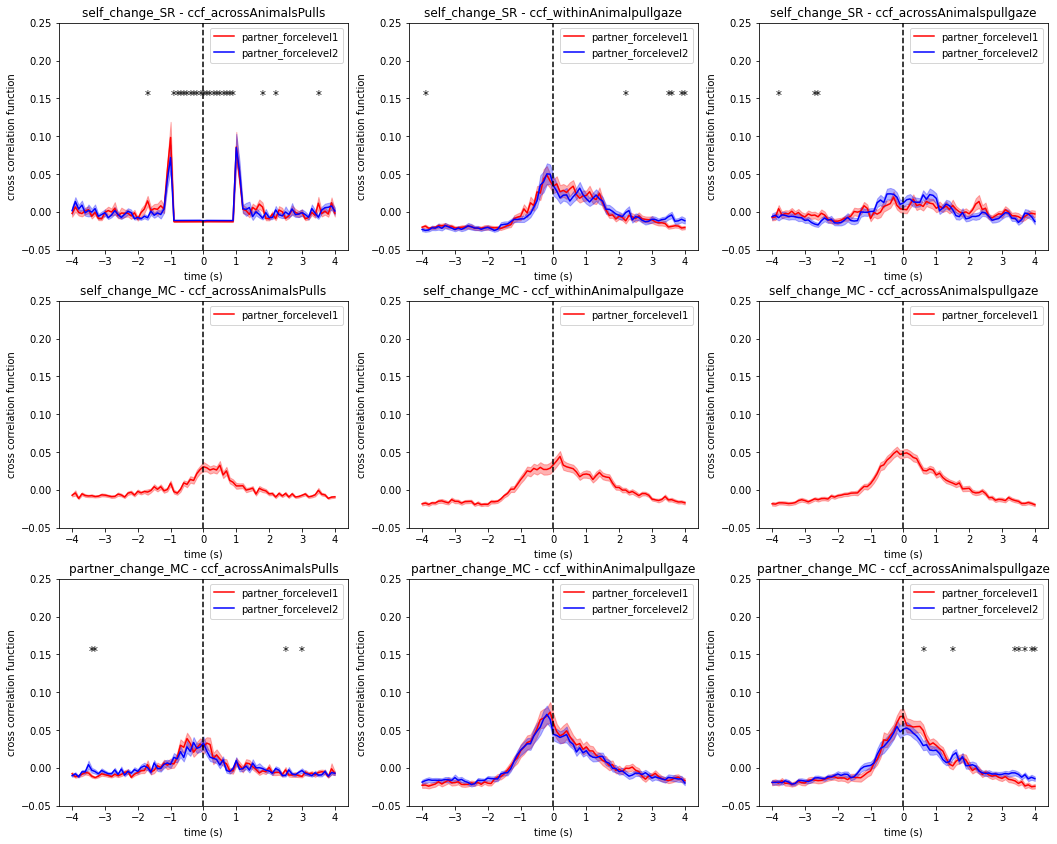

In [270]:
summary_all_tgt = summary_all_results_quantile

# Plotting each unique condition and y-axis type
unique_conditions = summary_all_tgt['forceContType'].unique()
# unique_conditions = ['self_change_SR']
# 
nTrialConds = np.shape(unique_conditions)[0]

# xplottype = 'subblockID' # 'succ_rate', 'subblockID', 'gazenum_pers', 'pullnum_pers'
xplottype = 'partner_force'  # 'self_force', 'partner_force'
nxplotgroups = np.shape(np.unique(summary_all_tgt[xplottype]))[0]
xplotgroupcolors = ['red','blue','green','skyblue','purple']

yplottypes = ['ccf_acrossAnimalsPulls','ccf_withinAnimalpullgaze','ccf_acrossAnimalspullgaze']
# yplottypes = ['ccf_acrossAnimalsPulls']
nyplottypes = np.shape(yplottypes)[0]

timebins = np.arange(-4,4.1,0.1)

# Set up the figure grid
fig, axes = plt.subplots(nTrialConds, nyplottypes, 
                         figsize=(5 * nyplottypes, 4 * nTrialConds), 
                         sharex=False, sharey=False)
fig.tight_layout(pad=3.0)



for i, condition in enumerate(unique_conditions):
    # Filter data for the current condition
    condition_data = summary_all_tgt[summary_all_tgt['forceContType'] == condition]
    
    for j, yplot in enumerate(yplottypes):
        ax = axes[i, j] if nTrialConds > 1 else axes[j]  # Adjust for single-row cases
        
        # create dataframe and then do statistic test
        condition_data_fortest = pd.concat([pd.DataFrame(condition_data[yplot].
                                                     reset_index(drop=True).values.tolist()),
                                        condition_data[xplottype].reset_index(drop=True)],axis=1)

        anova_results = {}
        for col in range(0, np.shape(condition_data_fortest)[1]-1):
            # Group the data by `partner_force`
            groups = [group[col].values for name, group in condition_data_fortest.groupby(xplottype)]
            # Filter out NaNs from each array in groups
            groups_cleaned = [g[~np.isnan(g)] for g in groups]

            # Run ANOVA on cleaned groups
            try:
                f_stat, p_value = st.f_oneway(*groups_cleaned)
            except:
                f_stat = np.nan
                p_value = np.nan
            # Store results
            anova_results[col] = {'F-statistic': f_stat, 'p-value': p_value}
        anova_results_df = pd.DataFrame(anova_results).T
        # print(anova_results_df)
     
        # for plot
        for ixplotgroup in np.arange(1,nxplotgroups+1,1):
            # group based on the force quantile
            condition_data_iforcequant = condition_data[condition_data[xplottype]==ixplotgroup]

            # real data
            data_cleaned = condition_data_iforcequant[yplot].reset_index(drop=True)

            data_clean_df = pd.DataFrame(data_cleaned.values.tolist())
            xxx_mean = np.nanmean(data_clean_df,axis=0)
            xxx_std = np.nanstd(data_clean_df,axis=0)/np.sqrt(np.shape(data_clean_df)[0])
            
            # # shuffled data
            # data_cleaned_sf = condition_data_iforcequant[yplot+'_shuffle'].reset_index(drop=True)
            # 
            # data_clean_sf_df = pd.DataFrame(data_cleaned_sf.values.tolist())
            # xxx_mean_sf = np.nanmean(data_clean_sf_df,axis=0)
            # xxx_std_sf = np.nanstd(data_clean_sf_df,axis=0)/np.sqrt(np.shape(data_clean_sf_df)[0])
            
            
            try:
                # real data
                seaborn.lineplot(x=timebins, y=xxx_mean, ax=ax,label=xplottype+'level'+str(ixplotgroup),
                                 color = xplotgroupcolors[ixplotgroup-1])
                ax.fill_between(timebins, xxx_mean - xxx_std, xxx_mean + xxx_std, alpha=0.3,
                                color = xplotgroupcolors[ixplotgroup-1])
                # # shuffled data
                # seaborn.lineplot(x=timebins, y=xxx_mean_sf, ax=ax,label=xplottype+'level'+str(ixplotgroup)+'shuffled',
                #                  color = xplotgroupcolors[ixplotgroup-1],linestyle='--')
                # ax.fill_between(timebins, xxx_mean_sf - xxx_std_sf, xxx_mean_sf + xxx_std_sf, alpha=0.1,
                #                 color = xplotgroupcolors[ixplotgroup-1])
            except:
                continue
        
        ax.set_ylim([-0.05,0.25])
        ax.plot([0,0],ax.get_ylim(),'k--')
        
        # Add significance markers outside of group loop
        for col, p_value in enumerate(anova_results_df['p-value']):
            if p_value < 0.06:  # Significance threshold
                # Slight vertical offset for the marker
                ax.text(timebins[col], 0.15, '*', ha='center', color='black', fontsize=12)

        
        # Set titles and labels
        ax.set_title(f"{condition} - {yplot}")
        # if i == nTrialConds - 1:
        ax.set_xlabel('time (s)')
        # if j == 0:
        ax.set_ylabel('cross correlation function')

            

plt.show()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents_allanimal_summary/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig.savefig(figsavefolder+"bhv_cross_corelation_groupedas"+xplottype+".pdf")



### plot the summarizing figures with all animals - separate animals
#### average cross correlation function 
#### separating condition (self sr, other sr, self mc, other mc etc)

In [ ]:
summary_all_tgt = summary_all_results_quantile

# Plotting each unique condition and y-axis type
unique_conditions = summary_all_tgt['forceContType'].unique()
#
nTrialConds = np.shape(unique_conditions)[0]

selfanimals = np.unique(summary_all_tgt['self_animal'])
nanimals = np.shape(selfanimals)[0]

# xplottype = 'subblockID'
xplottype = 'self_force'  # 'self_force', 'partner_force'
nxplotgroups = np.shape(np.unique(summary_all_tgt[xplottype]))[0]
xplotgroupcolors = ['red','blue','green','skyblue','purple']

yplottype = 'ccf_acrossAnimalsPulls' # 'ccf_acrossAnimalsPulls','ccf_withinAnimalpullgaze','ccf_acrossAnimalspullgaze'

timebins = np.arange(-4,4.1,0.1)

# Set up the figure grid
fig, axes = plt.subplots(nTrialConds, nanimals, 
                         figsize=(5 * nanimals, 4 * nTrialConds), 
                         sharex=False, sharey=False)
fig.tight_layout(pad=3.0)



for i, condition in enumerate(unique_conditions):
    # Filter data for the current condition
    condition_data = summary_all_tgt[summary_all_tgt['forceContType'] == condition]
    
    for j, ianimal in enumerate(selfanimals):
        ax = axes[i, j] if nTrialConds > 1 else axes[j]  # Adjust for single-row cases
        
        condition_data_ianimal = condition_data[condition_data['self_animal']==ianimal]

        # create dataframe and then do statistic test
        condition_data_fortest = pd.concat([pd.DataFrame(condition_data_ianimal[yplottype].
                                                     reset_index(drop=True).values.tolist()),
                                        condition_data_ianimal[xplottype].reset_index(drop=True)],axis=1)

        anova_results = {}
        for col in range(0, np.shape(condition_data_fortest)[1]-1):
            # Group the data by `partner_force`
            groups = [group[col].values for name, group in condition_data_fortest.groupby(xplottype)]
            # Filter out NaNs from each array in groups
            groups_cleaned = [g[~np.isnan(g)] for g in groups]

            # Run ANOVA on cleaned groups
            try:
                f_stat, p_value = st.f_oneway(*groups_cleaned)
            except:
                f_stat = np.nan
                p_value = np.nan
            # Store results
            anova_results[col] = {'F-statistic': f_stat, 'p-value': p_value}
        anova_results_df = pd.DataFrame(anova_results).T
        # print(anova_results_df)
        
        
        # for plot
        for ixplotgroup in np.arange(1,nxplotgroups+1,1):
            # group based on the force quantile
            condition_data_iforcequant_ianimal = condition_data_ianimal[condition_data_ianimal[xplottype]==ixplotgroup]
 
            # real data
            data_cleaned = condition_data_iforcequant_ianimal[yplottype].reset_index(drop=True)

            data_clean_df = pd.DataFrame(data_cleaned.values.tolist())
            xxx_mean = np.nanmean(data_clean_df,axis=0)
            xxx_std = np.nanstd(data_clean_df,axis=0)/np.sqrt(np.shape(data_clean_df)[0])
            
            # # shuffled data
            # data_cleaned_sf = condition_data_iforcequant_ianimal[yplottype+'_shuffle'].reset_index(drop=True)
            # 
            # data_clean_sf_df = pd.DataFrame(data_cleaned_sf.values.tolist())
            # xxx_mean_sf = np.nanmean(data_clean_sf_df,axis=0)
            # xxx_std_sf = np.nanstd(data_clean_sf_df,axis=0)/np.sqrt(np.shape(data_clean_sf_df)[0])
            
            try:
                # real data
                seaborn.lineplot(x=timebins, y=xxx_mean, ax=ax,label=xplottype+'level'+str(ixplotgroup),
                                 color = xplotgroupcolors[ixplotgroup-1])
                ax.fill_between(timebins, xxx_mean - xxx_std, xxx_mean + xxx_std, alpha=0.3,
                                color = xplotgroupcolors[ixplotgroup-1])
                # # shuffled data
                # seaborn.lineplot(x=timebins, y=xxx_mean_sf, ax=ax,label=xplottype+'level'+str(ixplotgroup)+'shuffled',
                #                  color = xplotgroupcolors[ixplotgroup-1],linestyle='--')
                # ax.fill_between(timebins, xxx_mean_sf - xxx_std_sf, xxx_mean_sf + xxx_std_sf, alpha=0.1,
                #                 color = xplotgroupcolors[ixplotgroup-1])
                
            except:
                continue
        
        ax.set_ylim([-0.05,0.25])
        ax.plot([0,0],ax.get_ylim(),'k--')
        
        # Add significance markers outside of group loop
        for col, p_value in enumerate(anova_results_df['p-value']):
            if p_value < 0.05:  # Significance threshold
                # Slight vertical offset for the marker
                ax.text(timebins[col], 0.15, '*', ha='center', color='black', fontsize=12)

        
        # Set titles and labels
        ax.set_title(f"{condition} - {yplottype}; {ianimal}")
        # if i == nTrialConds - 1:
        ax.set_xlabel('time (s)')
        # if j == 0:
        ax.set_ylabel('cross correlation function')
            

plt.show()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents_allanimal_summary/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig.savefig(figsavefolder+"bhv_cross_corelation_groupedas"+xplottype+"_"+yplottype+"_separateanimals.pdf")



In [ ]:
summary_all_tgt['forceContType'].unique()